### Linking textbook sections to exercises through an AI-based recommender system

In [12]:
import pandas as pd
import json
from bs4 import BeautifulSoup
from sentence_transformers import SentenceTransformer#, util
from sklearn.metrics.pairwise import cosine_similarity

import numpy as np
import heapq
from nltk.tokenize import TreebankWordTokenizer
import string
from nltk.stem import SnowballStemmer


import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords


from gensim import corpora, models, similarities

from gensim.models.doc2vec import Doc2Vec, TaggedDocument


### Data pre-processing

In [13]:
url_folder='/path_to_file'

para_heading_list_under_section=pd.read_csv(url_folder+'para_heading_list_under_section_standard.csv')  

#Instudering
exeName_paraComponents_onlynodesname_Instuderingsfragor_andPara\
=pd.read_csv(url_folder+'exeName_paraComponents_onlynodesname_Instuderingsfragor_andPara_standard.csv')  

#Quiz
QuizAndCorrectAnswers\
=pd.read_csv(url_folder+'QuizAndCorrectAnswers_standard.csv')  
QuizAndCorrectAnswers=QuizAndCorrectAnswers[['book_id','area_id','content_id','collection_id','exe_id','exe_header','text_in_components','q_alt']]


In [15]:
def parse_text(df,raw_text_col_to_filter,new_col_name):
    clean_text=[]
    for row in df[raw_text_col_to_filter]:  
        clean_text_p=BeautifulSoup(str(row), "html.parser").get_text()
        clean_text_p=clean_text_p.replace("\n", "").replace("\u2028", "").replace("&nbsp", "").replace(u'\xa0', ' ')
    df[new_col_name]=clean_text

parse_text(para_heading_list_under_section,'t','clean_text')
parse_text(exeName_paraComponents_onlynodesname_Instuderingsfragor_andPara,'text_in_components','text_in_components') 
parse_text(QuizAndCorrectAnswers,'text_in_components','text_in_components')
parse_text(QuizAndCorrectAnswers,'q_alt','q_alt')

In [16]:
exe_id_combined_comp=QuizAndCorrectAnswers[['exe_id','text_in_components']].drop_duplicates().groupby(['exe_id'])['text_in_components'].apply(' '.join).reset_index()
exe_id_combined_qAlt=QuizAndCorrectAnswers[['exe_id','q_alt']].drop_duplicates().groupby(['exe_id'])['q_alt'].apply(' '.join).reset_index()
quiz=pd.merge(pd.merge(exe_id_combined_comp, exe_id_combined_qAlt, how="inner", on=["exe_id"]),QuizAndCorrectAnswers, how='inner',on=['exe_id'])[['book_id','area_id','content_id','collection_id','exe_id','exe_header','text_in_components_x','q_alt_x']].drop_duplicates()
quiz["q_and_correct_alt"] = quiz["text_in_components_x"] + ' ' + quiz["q_alt_x"] 
quiz=quiz.reset_index(drop=True)

In [ ]:
para_len_token=[]
para_len_sen=[]
l=0
l_sen=0
num_len_greater_512=num_len_greater_512=0
for i in para_heading_list_under_section['clean_text']:
    para_len_token.append(len(word_tokenize(i)))
    para_len_sen.append(len(sentence_tokenize(i)))
    l=l+len(word_tokenize(i))
    l_sen=l_sen+len(sentence_tokenize(i))
    if len(word_tokenize(i))>512:
        num_len_greater_512=num_len_greater_512+1
        print(len(word_tokenize(i)))

print('total paragraph',len(para_heading_list_under_section))
print('total unique paragraph',len(para_heading_list_under_section['t'].unique()))
print('total tokens',l)
print('average tokens per paragraph',sum(para_len_token)/len(para_len_token))
print('longest paragraph',max(para_len_token))

print('total # sentences',l_sen)
print('average tokens per paragraph',sum(para_len_token)/len(para_len_token))
print('longest paragraph',max(para_len_token))

print('# paragraph-length over 512', num_len_greater_512)
print('% paragraph-length over 512',num_len_greater_512/len(para_len_token))


### BERT embedding

In [2]:
model = SentenceTransformer('KBLab/sentence-bert-swedish-cased')
content_embeddings = model.encode(para_heading_list_under_section['clean_text']) 
exe_embeddings = model.encode(exeName_paraComponents_onlynodesname_Instuderingsfragor_andPara['text_in_components']) 
quiz_embeddings = model.encode(list(quiz['q_and_correct_alt']) ) 

In [ ]:
print(exe_embeddings.shape )
print(quiz_embeddings.shape )
print(content_embeddings.shape )

### Adjusted-mean paragraph pooling BERT - avg(cos_sim(exercise,paragraph))

In [48]:
def sim_recommend_result(df1, df2, df1TextIdenColValue_addToDf2Col,text_col1_embeddings,text_col2_embeddings, true_rec_benchmark_col_name1, true_rec_benchmark_col_name2, best_nr):
    pred_recall=[]
    pred_precision=[]
    pred_area=[]
    pred_area1=[]
    rr=0
    previous=[]
    current=[]
    future=[]
    previous1=[]
    current1=[]
    future1=[] 
    
    for i in  range(len(df1)): 

        cs=cosine_similarity([text_col1_embeddings[i]],text_col2_embeddings[:])

        column_name=list(df1[df1TextIdenColValue_addToDf2Col])[i]
        df2[column_name]=cs[0]
        i_agg=df2.groupby(true_rec_benchmark_col_name2)[column_name].mean().to_frame()

        ind1=i_agg.nlargest(1,column_name).index
        ind_bestnr=i_agg.nlargest(best_nr,column_name).index
        ind_all=i_agg.nlargest(len(i_agg),column_name).index
        

        if list(df1[true_rec_benchmark_col_name1])[i] in  ind_bestnr:
            pred_recall.append(1)
        else: 
            pred_recall.append(0)

        if list(df1[true_rec_benchmark_col_name1])[i] in ind1:
            pred_precision.append(1)
        else: 
            pred_precision.append(0)
        

        rr=rr+(1/(list(ind_all).index(list(df1[true_rec_benchmark_col_name1])[i])+1))


        for j in ind_bestnr:

            if j in list(df1[df1['area_id']==df1['area_id'][i]][true_rec_benchmark_col_name1].drop_duplicates()):
                pred_area.append(1)

            else: 
                pred_area.append(0)
        
                
        if ind1 in list(df1[df1['area_id']==df1['area_id'][i]][true_rec_benchmark_col_name1].drop_duplicates()):
            pred_area1.append(1)

        else: 
            pred_area1.append(0)
                
        for j in ind_bestnr:
            if content_order.index(j) < content_order.index(list(df1[true_rec_benchmark_col_name1])[i]):
                previous.append(1)
            elif content_order.index(j) > content_order.index(list(df1[true_rec_benchmark_col_name1])[i]):
                future.append(1)
            else:
                current.append(1)
           
        if content_order.index(ind1) < content_order.index(list(df1[true_rec_benchmark_col_name1])[i]):
            previous1.append(1)
        elif content_order.index(ind1) > content_order.index(list(df1[true_rec_benchmark_col_name1])[i]):
            future1.append(1)
        else:
            current1.append(1)       
        
        
    
    print('Recall@'+str(best_nr)+':', sum(pred_recall) / len(pred_recall))
    print('Precision@1'+':', sum(pred_precision) / len(pred_precision))
    print('MRR:',rr/len(df1))
    print('Recall_Area@'+str(best_nr)+':', sum(pred_area) / len(pred_area))
    print('Recall_Area@1:', sum(pred_area1) / len(pred_area1))
    
    print('Recommended Previous No:', sum(previous))
    print('Recommended Current No:', sum(current))
    print('Recommended Future No:', sum(future))
    print('Recommended Previous %:', sum(previous)/(len(df1)*3))
    print('Recommended Current %:', sum(current)/(len(df1)*3))
    print('Recommended Future %:', sum(future)/(len(df1)*3))

    print('Recommended@1 Previous No:', sum(previous1))
    print('Recommended@1 Current No:', sum(current1))
    print('Recommended@1 Future No:', sum(future1))
    print('Recommended@1 Previous %:', sum(previous1)/len(df1))
    print('Recommended@1 Current %:', sum(current1)/len(df1))
    print('Recommended@1 Future %:', sum(future1)/len(df1))




In [72]:
print('Concept name')
print('AVG wordName VS section_header_name best3')
sim_recommend_result(word_and_explanation, section_header_name,'name',word_name_embeddings, section_name_embeddings, 'content_id','content_id', 3)
print('\n')
print('AVG wordName VS paragraphs best3')
sim_recommend_result(word_and_explanation, para_heading_list_under_section,'name',word_name_embeddings, content_embeddings, 'content_id','content_id', 3)

print('\n')
print('Concept and explanation')
print('AVG wordExp VS section_header_name best3')
sim_recommend_result(word_and_explanation, section_header_name,'name',wordExp_embeddings, section_name_embeddings, 'content_id','content_id', 3)

print('\n')
print('AVG wordExp VS paragraphs best3')
sim_recommend_result(word_and_explanation, para_heading_list_under_section,'name', wordExp_embeddings, content_embeddings, 'content_id','content_id', 3)

print('\n')
print('Instudering')
print('AVG Instudering VS section_header_name best3')
sim_recommend_result(exeName_paraComponents_onlynodesname_Instuderingsfragor_andPara, section_header_name,'exe_id', exe_embeddings, section_name_embeddings, 'content_id','content_id', 3)

print('\n')
print('AVG Instudering VS paragraphs best3')
sim_recommend_result(exeName_paraComponents_onlynodesname_Instuderingsfragor_andPara, para_heading_list_under_section,'exe_id', exe_embeddings, content_embeddings, 'content_id','content_id', 3)

print('\n')
print('Quiz')
print('AVG Quiz VS section_header_name best3')
sim_recommend_result(quiz, section_header_name,'exe_id', quiz_embeddings, section_name_embeddings, 'content_id','content_id', 3)

print('\n')
print('AVG Quiz VS paragraphs best3')
sim_recommend_result(quiz, para_heading_list_under_section,'exe_id', quiz_embeddings, content_embeddings, 'content_id','content_id', 3)


Concept name
AVG wordName VS section_header_name best3
Recall@3: 0.4435483870967742
Precision@1: 0.17204301075268819
MRR: 0.351342406315957
Recall_Area@3: 0.2867383512544803
Recall_Area@1: 0.25
Recommended Previous No: 509
Recommended Current No: 165
Recommended Future No: 442
Recommended Previous %: 0.4560931899641577
Recommended Current %: 0.1478494623655914
Recommended Future %: 0.3960573476702509
Recommended@1 Previous No: 150
Recommended@1 Current No: 64
Recommended@1 Future No: 158
Recommended@1 Previous %: 0.4032258064516129
Recommended@1 Current %: 0.17204301075268819
Recommended@1 Future %: 0.42473118279569894


AVG wordName VS paragraphs best3
Recall@3: 0.6236559139784946
Precision@1: 0.4032258064516129
MRR: 0.5413930638363675
Recall_Area@3: 0.38799283154121866
Recall_Area@1: 0.5295698924731183
Recommended Previous No: 417
Recommended Current No: 232
Recommended Future No: 467
Recommended Previous %: 0.3736559139784946
Recommended Current %: 0.2078853046594982
Recommended Fut

### MAX paragraph-level pooling - BERT - max(cos_sim(exercises,paragraphs))

In [53]:
def sim_recommend_result_max(df1, df2, df1TextIdenColValue_addToDf2Col, text_col1_embeddings,text_col2_embeddings, true_rec_benchmark_col_name1, true_rec_benchmark_col_name2, best_nr):
    pred_recall=[]
    pred_precision=[]
    pred_area=[]
    pred_area1=[]
    rr=0
    previous=[]
    current=[]
    future=[]
    previous1=[]
    current1=[]
    future1=[] 

    for i in range(len(df1)):

        cs=cosine_similarity([text_col1_embeddings[i]],text_col2_embeddings[:])

        column_name=list(df1[df1TextIdenColValue_addToDf2Col])[i]
        df2[column_name]=cs[0]
        i_agg=df2.groupby(true_rec_benchmark_col_name2)[column_name].max().to_frame()

        ind1=i_agg.nlargest(1,column_name).index
        ind_bestnr=i_agg.nlargest(best_nr,column_name).index
        ind_all=i_agg.nlargest(len(i_agg),column_name).index
        
        if list(df1[true_rec_benchmark_col_name1])[i] in ind_bestnr:
            pred_recall.append(1)
        else: 
            pred_recall.append(0)

        if list(df1[true_rec_benchmark_col_name1])[i] in ind1:
            pred_precision.append(1)
        else: 
            pred_precision.append(0)
        

        rr=rr+(1/(list(ind_all).index(list(df1[true_rec_benchmark_col_name1])[i])+1))


        for j in ind_bestnr:

            if j in list(df1[df1['area_id']==df1['area_id'][i]][true_rec_benchmark_col_name1].drop_duplicates()):
                pred_area.append(1)

            else: 
                pred_area.append(0)
        
       
        if ind1 in list(df1[df1['area_id']==df1['area_id'][i]][true_rec_benchmark_col_name1].drop_duplicates()):
            pred_area1.append(1)

        else: 
            pred_area1.append(0)
                
        for j in ind_bestnr:
            if content_order.index(j) < content_order.index(list(df1[true_rec_benchmark_col_name1])[i]):
                previous.append(1)
            if content_order.index(j) > content_order.index(list(df1[true_rec_benchmark_col_name1])[i]):
                future.append(1)
            if content_order.index(j) == content_order.index(list(df1[true_rec_benchmark_col_name1])[i]):
                current.append(1)

        if content_order.index(ind1) < content_order.index(list(df1[true_rec_benchmark_col_name1])[i]):
            previous1.append(1)
        elif content_order.index(ind1) > content_order.index(list(df1[true_rec_benchmark_col_name1])[i]):
            future1.append(1)
        else: 
            current1.append(1)       
        
        
    
    print('Recall@'+str(best_nr)+':', sum(pred_recall) / len(pred_recall))
    print('Precision@1'+':', sum(pred_precision) / len(pred_precision))
    print('MRR:',rr/len(df1))
    print('Recall_Area@'+str(best_nr)+':', sum(pred_area) / len(pred_area))
    print('Recall_Area@1:', sum(pred_area1) / len(pred_area1))
    
    print('Recommended Previous No:', sum(previous))
    print('Recommended Current No:', sum(current))
    print('Recommended Future No:', sum(future))
    print('Recommended Previous %:', sum(previous)/(len(df1)*3))
    print('Recommended Current %:', sum(current)/(len(df1)*3))
    print('Recommended Future %:', sum(future)/(len(df1)*3))

    print('Recommended@1 Previous No:', sum(previous1))
    print('Recommended@1 Current No:', sum(current1))
    print('Recommended@1 Future No:', sum(future1))
    print('Recommended@1 Previous %:', sum(previous1)/len(df1))
    print('Recommended@1 Current %:', sum(current1)/len(df1))
    print('Recommended@1 Future %:', sum(future1)/len(df1))


In [54]:
print('Concept name')
print('MAX wordName VS section_header_name best3')
sim_recommend_result_max(word_and_explanation, section_header_name,'name',word_name_embeddings, section_name_embeddings, 'content_id','content_id', 3)
print('MAX wordName VS paragraphs best3')
sim_recommend_result_max(word_and_explanation, para_heading_list_under_section,'name',word_name_embeddings, content_embeddings, 'content_id','content_id', 3)

print('\n')
print('Concept and explanation')
print('MAX wordExp VS section_header_name best3')
sim_recommend_result_max(word_and_explanation, section_header_name, 'name', wordExp_embeddings, section_name_embeddings, 'content_id','content_id', 3)

print('\n')
print('MAX wordExp VS paragraphs best3')
sim_recommend_result_max(word_and_explanation, para_heading_list_under_section, 'name', wordExp_embeddings, content_embeddings, 'content_id','content_id', 3)

print('\n')
print('Instudering') 
print('MAX Instudering VS section_header_name best3')
sim_recommend_result_max(exeName_paraComponents_onlynodesname_Instuderingsfragor_andPara, section_header_name, 'exe_id', exe_embeddings, section_name_embeddings, 'content_id','content_id', 3)

print('\n')
print('MAX Instudering VS paragraphs best3')
sim_recommend_result_max(exeName_paraComponents_onlynodesname_Instuderingsfragor_andPara, para_heading_list_under_section, 'exe_id', exe_embeddings, content_embeddings, 'content_id','content_id', 3)

print('\n')
print('Quiz')
print('MAX Quiz VS section_header_name best3')
sim_recommend_result_max(quiz, section_header_name, 'exe_id', quiz_embeddings, section_name_embeddings, 'content_id','content_id', 3)

print('\n')
print('MAX Quiz VS paragraphs best3')
sim_recommend_result_max(quiz, para_heading_list_under_section, 'exe_id', quiz_embeddings, content_embeddings, 'content_id','content_id', 3)


Concept name
MAX wordName VS section_header_name best3
Recall@3: 0.5241935483870968
Precision@1: 0.3629032258064516
MRR: 0.48511819771155035
Recall_Area@3: 0.31362007168458783
Recall_Area@1: 0.4596774193548387
Recommended Previous No: 378
Recommended Current No: 195
Recommended Future No: 543
Recommended Previous %: 0.3387096774193548
Recommended Current %: 0.17473118279569894
Recommended Future %: 0.48655913978494625
Recommended@1 Previous No: 90
Recommended@1 Current No: 135
Recommended@1 Future No: 147
Recommended@1 Previous %: 0.24193548387096775
Recommended@1 Current %: 0.3629032258064516
Recommended@1 Future %: 0.3951612903225806
MAX wordName VS paragraphs best3
Recall@3: 0.6451612903225806
Precision@1: 0.3897849462365591
MRR: 0.503390974062037
Recall_Area@3: 0.33602150537634407
Recall_Area@1: 0.4731182795698925
Recommended Previous No: 312
Recommended Current No: 240
Recommended Future No: 564
Recommended Previous %: 0.27956989247311825
Recommended Current %: 0.21505376344086022

### Mean paragraph-level pooling BERT  - cos_sim(avg(paragraphs embedding), avg(exercise embedding))

In [57]:
def avg_embedding(df1, df2, text_col1_embeddings,text_col2_embeddings, true_rec_benchmark_col_name1, true_rec_benchmark_col_name2, best_nr):

    pred=[]
    for i in  range(len(df1)): 
        dict=df2.groupby(true_rec_benchmark_col_name2).indices
        key_contentId=[]
        avg_embedding=[]
        for (k, v) in dict.items():
            avg_embedding_p=text_col2_embeddings[v].mean(axis=0)
            avg_embedding.append(avg_embedding_p)
            key_contentId.append(k)
        
        cs=cosine_similarity([text_col1_embeddings[i]],avg_embedding[:])

        cs_df= pd.DataFrame({'key_contentId':key_contentId,'similarity': cs[0]})
        if list(df1[true_rec_benchmark_col_name1])[i] in list(cs_df.nlargest(best_nr,'similarity')['key_contentId']):
            pred.append(1)
        else: 
            pred.append(0)
           
    print(sum(pred) / len(pred))

In [58]:
def avg_embedding(df1, df2, text_col1_embeddings,text_col2_embeddings, true_rec_benchmark_col_name1, true_rec_benchmark_col_name2, best_nr):
    pred_recall=[]
    pred_precision=[]
    pred_area=[]
    pred_area1=[]
    rr=0
    previous=[]
    current=[]
    future=[]
    previous1=[]
    current1=[]
    future1=[] 
    for i in  range(len(df1)): 
        dict=df2.groupby(true_rec_benchmark_col_name2).indices
        key_contentId=[]
        avg_embedding=[]
        for (k, v) in dict.items():
            avg_embedding_p=text_col2_embeddings[v].mean(axis=0)
            avg_embedding.append(avg_embedding_p)
            key_contentId.append(k)
        
        cs=cosine_similarity([text_col1_embeddings[i]],avg_embedding[:])

        cs_df= pd.DataFrame({'key_contentId':key_contentId,'similarity': cs[0]})
        
        ind1=list(cs_df.nlargest(1,'similarity')['key_contentId'])
        ind_bestnr=list(cs_df.nlargest(best_nr,'similarity')['key_contentId'])
        ind_all=list(cs_df.nlargest(len(cs_df),'similarity')['key_contentId'])
        
        if list(df1[true_rec_benchmark_col_name1])[i] in ind_bestnr:
            pred_recall.append(1)
        else: 
            pred_recall.append(0)

        if list(df1[true_rec_benchmark_col_name1])[i] in ind1:
            pred_precision.append(1)
        else: 
            pred_precision.append(0)
        

        rr=rr+(1/(list(ind_all).index(list(df1[true_rec_benchmark_col_name1])[i])+1))


        for j in ind_bestnr:

            if j in list(df1[df1['area_id']==df1['area_id'][i]][true_rec_benchmark_col_name1].drop_duplicates()):
                pred_area.append(1)

            else: 
                pred_area.append(0)
        
                
        if ind1[0] in list(df1[df1['area_id']==df1['area_id'][i]][true_rec_benchmark_col_name1].drop_duplicates()):
            pred_area1.append(1)

        else: 
            pred_area1.append(0)
      
        for j in ind_bestnr:
            if content_order.index(j) < content_order.index(list(df1[true_rec_benchmark_col_name1])[i]):
                previous.append(1)
            if content_order.index(j) > content_order.index(list(df1[true_rec_benchmark_col_name1])[i]):
                future.append(1)
            if content_order.index(j) == content_order.index(list(df1[true_rec_benchmark_col_name1])[i]):
                current.append(1)
            
        if content_order.index(ind1[0]) < content_order.index(list(df1[true_rec_benchmark_col_name1])[i]):
            previous1.append(1)
        elif content_order.index(ind1[0]) > content_order.index(list(df1[true_rec_benchmark_col_name1])[i]):
            future1.append(1)
        else:
            current1.append(1)       
        
        
    
    print('Recall@'+str(best_nr)+':', sum(pred_recall) / len(pred_recall))
    print('Precision@1'+':', sum(pred_precision) / len(pred_precision))
    print('MRR:',rr/len(df1))
    print('Recall_Area@'+str(best_nr)+':', sum(pred_area) / len(pred_area))
    print('Recall_Area@1:', sum(pred_area1) / len(pred_area1))
    
    print('Recommended Previous No:', sum(previous))
    print('Recommended Current No:', sum(current))
    print('Recommended Future No:', sum(future))
    print('Recommended Previous %:', sum(previous)/(len(df1)*3))
    print('Recommended Current %:', sum(current)/(len(df1)*3))
    print('Recommended Future %:', sum(future)/(len(df1)*3))

    print('Recommended@1 Previous No:', sum(previous1))
    print('Recommended@1 Current No:', sum(current1))
    print('Recommended@1 Future No:', sum(future1))
    print('Recommended@1 Previous %:', sum(previous1)/len(df1))
    print('Recommended@1 Current %:', sum(current1)/len(df1))
    print('Recommended@1 Future %:', sum(future1)/len(df1))




In [89]:
print('Concept name')
print('AVG_EMBEDDING wordName VS section_header_name best3')
avg_embedding(word_and_explanation, section_header_name,word_name_embeddings, section_name_embeddings, 'content_id','content_id', 3)
print('\n')
print('AVG_EMBEDDING wordName VS paragraphs best3')
avg_embedding(word_and_explanation, para_heading_list_under_section, word_name_embeddings, content_embeddings, 'content_id','content_id', 3)



print('\n')
print('Concept and explanation')
print('AVG_EMBEDDING wordExp VS section_header_name best3')
avg_embedding(word_and_explanation, section_header_name,wordExp_embeddings, section_name_embeddings, 'content_id','content_id', 3)
print('\n')
print('AVG_EMBEDDING wordExp VS paragraphs best3')
avg_embedding(word_and_explanation, para_heading_list_under_section,wordExp_embeddings, content_embeddings, 'content_id','content_id', 3)

print('\n')
print('Instudering')
print('AVG_EMBEDDING Instudering VS section_header_name best3')
avg_embedding(exeName_paraComponents_onlynodesname_Instuderingsfragor_andPara, section_header_name,exe_embeddings, section_name_embeddings, 'content_id','content_id', 3)
print('\n')
print('AVG_EMBEDDING Instudering VS paragraphs best3')
avg_embedding(exeName_paraComponents_onlynodesname_Instuderingsfragor_andPara, para_heading_list_under_section,exe_embeddings, content_embeddings, 'content_id','content_id', 3)


print('\n')
print('Quiz')
print('AVG_EMBEDDING Quiz VS section_header_name best3')
avg_embedding(quiz, section_header_name, quiz_embeddings, section_name_embeddings, 'content_id','content_id', 3)

print('\n')
print('AVG_EMBEDDING Quiz VS paragraphs best3')
avg_embedding(quiz, para_heading_list_under_section, quiz_embeddings, content_embeddings, 'content_id','content_id', 3)


Concept name
AVG_EMBEDDING wordName VS section_header_name best3
Recall@3: 0.43009605122732125
Precision@1: 0.27321237993596587
MMR: 0.3924553022308533
Recall_Area@3: 0.327641408751334
Recall_Area@1: 0.4311632870864461
Recommended Previous No: 1117
Recommended Current No: 403
Recommended Future No: 1291
Recommended Previous %: 0.39736748488082535
Recommended Current %: 0.14336535040910708
Recommended Future %: 0.45926716471006757
Recommended@1 Previous No: 269
Recommended@1 Current No: 256
Recommended@1 Future No: 412
Recommended@1 Previous %: 0.2870864461045891
Recommended@1 Current %: 0.27321237993596587
Recommended@1 Future %: 0.439701173959445


AVG_EMBEDDING wordName VS paragraphs best3
Recall@3: 0.4215581643543223
Precision@1: 0.2700106723585913
MMR: 0.39265866260244264
Recall_Area@3: 0.27392387050871575
Recall_Area@1: 0.3820704375667022
Recommended Previous No: 1081
Recommended Current No: 395
Recommended Future No: 1335
Recommended Previous %: 0.38456065457132693
Recommended Cu

### Exercise -> Textbook section: TF-IDF

In [20]:
stemmer = SnowballStemmer("swedish") #automatic .lower()
stop_words = list(stopwords.words('swedish'))

def text_preprocessing(sent):
    """
    Pre processing text to removeunnecessary words.
    """    
    stop_words = set(stopwords.words('swedish'))
    clean_words = []
    words = word_tokenize(sent,language='swedish')
    words=[word.translate(str.maketrans('', '', string.punctuation)) for word in words] 
    words = [stemmer.stem(word) for word in words if word!='']
    clean_words = [word for word in words if word not in stop_words]
    return clean_words


In [64]:
def tfidf_model(corpus_df, corpus_df_col):
    dictionary = corpora.Dictionary(text_preprocessing(r) for r in corpus_df[corpus_df_col])
    corpus = [dictionary.doc2bow(text_preprocessing(r)) for r in corpus_df[corpus_df_col]]
    tfidf = models.TfidfModel(corpus)
    index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features=len(dictionary)) 
    return tfidf, index, dictionary

tfidf, index, dictionary=tfidf_model(para_heading_list_under_section,'clean_text')

In [65]:
def tfidf_sim(new_df,corpus_df, df1TextIdenColValue_addToDf2Col,new_df_col,new_df_benchmark_col,corpus_benchmark_col,best_nr):
    pred_recall=[]
    pred_precision=[]
    pred_area=[]
    pred_area1=[]
    rr=0
    previous=[]
    current=[]
    future=[]
    previous1=[]
    current1=[]
    future1=[] 

    for i in range(len(new_df)):
        doc=list(new_df[new_df_col])[i]
        iden=list(new_df[df1TextIdenColValue_addToDf2Col])[i]
        vec_bow = dictionary.doc2bow(text_preprocessing(doc)) 
        vec_tfidf = tfidf[vec_bow]
        sims = list(index[vec_tfidf]) # perform a similarity query against the corpus
        column_name=iden+'_tfidf_simt'
        corpus_df[column_name]=sims

        i_agg=corpus_df.groupby(corpus_benchmark_col)[column_name].max().to_frame()

        ind1=i_agg.nlargest(1,column_name).index
        ind_bestnr=i_agg.nlargest(best_nr,column_name).index
        ind_all=i_agg.nlargest(len(i_agg),column_name).index
            
        if list(new_df[new_df_benchmark_col])[i] in ind_bestnr:
            pred_recall.append(1)
        else: 
            pred_recall.append(0)

        if list(new_df[new_df_benchmark_col])[i] in ind1:
            pred_precision.append(1)
        else: 
            pred_precision.append(0)
        

        rr=rr+(1/(list(ind_all).index(list(new_df[new_df_benchmark_col])[i])+1))


        for j in ind_bestnr:

            if j in list(new_df[new_df['area_id']==new_df['area_id'][i]][new_df_benchmark_col].drop_duplicates()):
                pred_area.append(1)

            else: 
                pred_area.append(0)
        
       
        if ind1 in list(new_df[new_df['area_id']==new_df['area_id'][i]][new_df_benchmark_col].drop_duplicates()):
            pred_area1.append(1)

        else: 
            pred_area1.append(0)
                
        for j in ind_bestnr:
            if content_order.index(j) < content_order.index(list(new_df[new_df_benchmark_col])[i]):
                previous.append(1)
            if content_order.index(j) > content_order.index(list(new_df[new_df_benchmark_col])[i]):
                future.append(1)
            if content_order.index(j) == content_order.index(list(new_df[new_df_benchmark_col])[i]):
                current.append(1)

        if content_order.index(ind1) < content_order.index(list(new_df[new_df_benchmark_col])[i]):
            previous1.append(1)
        elif content_order.index(ind1) > content_order.index(list(new_df[new_df_benchmark_col])[i]):
            future1.append(1)
        else: 
            current1.append(1)       
        
        
    
    print('Recall@'+str(best_nr)+':', sum(pred_recall) / len(pred_recall))
    print('Precision@1'+':', sum(pred_precision) / len(pred_precision))
    print('MRR:',rr/len(new_df))
    print('Recall_Area@'+str(best_nr)+':', sum(pred_area) / len(pred_area))
    print('Recall_Area@1:', sum(pred_area1) / len(pred_area1))
    
    print('Recommended Previous No:', sum(previous))
    print('Recommended Current No:', sum(current))
    print('Recommended Future No:', sum(future))
    print('Recommended Previous %:', sum(previous)/(len(new_df)*3))
    print('Recommended Current %:', sum(current)/(len(new_df)*3))
    print('Recommended Future %:', sum(future)/(len(new_df)*3))

    print('Recommended@1 Previous No:', sum(previous1))
    print('Recommended@1 Current No:', sum(current1))
    print('Recommended@1 Future No:', sum(future1))
    print('Recommended@1 Previous %:', sum(previous1)/len(new_df))
    print('Recommended@1 Current %:', sum(current1)/len(new_df))
    print('Recommended@1 Future %:', sum(future1)/len(new_df))

In [73]:
print('Concept name')
print('tfidf MAX wordName VS paragraphs best3')
tfidf_sim(word_and_explanation, para_heading_list_under_section,'name','name','content_id','content_id', 3)

print('\n')
print('Concept and explanation')
print('tfidf MAX wordExp VS paragraphs best3')
tfidf_sim(word_and_explanation, para_heading_list_under_section, 'name','word_and_explanation','content_id','content_id', 3)

print('\n')
print('Instudering') 
print('tfidf MAX Instudering VS paragraphs best3')
tfidf_sim(exeName_paraComponents_onlynodesname_Instuderingsfragor_andPara,para_heading_list_under_section, 'exe_id','text_in_components','content_id','content_id',3)

print('\n')
print('Quiz')
print('tfidf MAX Quiz VS paragraphs best3')
tfidf_sim(quiz,para_heading_list_under_section, 'exe_id','q_and_correct_alt','content_id','content_id',3) 

Concept name
tfidf MAX wordName VS paragraphs best3
Recall@3: 0.9005376344086021
Precision@1: 0.5967741935483871
MRR: 0.7405061247789502
Recall_Area@3: 0.3835125448028674
Recall_Area@1: 0.6451612903225806
Recommended Previous No: 105
Recommended Current No: 335
Recommended Future No: 676
Recommended Previous %: 0.09408602150537634
Recommended Current %: 0.300179211469534
Recommended Future %: 0.6057347670250897
Recommended@1 Previous No: 18
Recommended@1 Current No: 222
Recommended@1 Future No: 132
Recommended@1 Previous %: 0.04838709677419355
Recommended@1 Current %: 0.5967741935483871
Recommended@1 Future %: 0.3548387096774194


Concept and explanation
tfidf MAX wordExp VS paragraphs best3
Recall@3: 0.9381720430107527
Precision@1: 0.6774193548387096
MRR: 0.7998613244580988
Recall_Area@3: 0.43010752688172044
Recall_Area@1: 0.728494623655914
Recommended Previous No: 232
Recommended Current No: 349
Recommended Future No: 535
Recommended Previous %: 0.2078853046594982
Recommended Current

### Exercise -> Textbook section: Doc2Vec


In [ ]:
# training with epochs
tagged_data = [TaggedDocument(words=text_preprocessing(doc), tags=[str(i)]) for i, doc in enumerate(list(para_heading_list_under_section['clean_text']))]

max_epochs = 10
vec_size = 400
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=2,
                dbow_words = 1,
                dm =0)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    model.alpha -= 0.0002
    model.min_alpha = model.alpha


In [68]:
def doc2vec_max_sim_preprocessed(df1,df2,df1_col,df1_benchmark_col,df2_benchmark_col,best_nr):
    pred_recall=[]
    pred_precision=[]
    pred_area=[]
    pred_area1=[]
    rr=0
    previous=[]
    current=[]
    future=[]
    previous1=[]
    current1=[]
    future1=[] 
    
    for i in range(len(df1)):
        doc=text_preprocessing(list(df1[df1_col])[i])
        v1 = model.infer_vector(doc)
        similar_doc = model.docvecs.most_similar([v1],topn=len(df2))
                
        ranked_contentID=[]
        for k in range(len(df2)):
            ind=int(similar_doc[k][0])
            new_contentID=list(df2[df2_benchmark_col])[ind]
            if new_contentID not in ranked_contentID:
                ranked_contentID.append(list(df2[df2_benchmark_col])[ind])
        
        ind1=ranked_contentID[0]
        ind_bestnr=ranked_contentID[:best_nr]
        ind_all=ranked_contentID
        
        if list(df1[df1_benchmark_col])[i] in ind_bestnr:
            pred_recall.append(1)
        else: 
            pred_recall.append(0)        

        if list(df1[df1_benchmark_col])[i] in [ind1]:
            pred_precision.append(1)
        else: 
            pred_precision.append(0)            
            
            
        rr=rr+(1/(list(ranked_contentID).index(list(df1[df1_benchmark_col])[i])+1))    

        for j in ind_bestnr:
            if j in list(df1[df1['area_id']==df1['area_id'][i]][df1_benchmark_col].drop_duplicates()):
                pred_area.append(1)
            else: 
                pred_area.append(0)       

        if ind1 in list(df1[df1['area_id']==df1['area_id'][i]][df1_benchmark_col].drop_duplicates()):
            pred_area1.append(1)
        else: 
            pred_area1.append(0)

            
        for j in ind_bestnr:

            if content_order.index(j) < content_order.index(list(df1[df1_benchmark_col])[i]):
                previous.append(1)
            elif content_order.index(j) > content_order.index(list(df1[df1_benchmark_col])[i]):
                future.append(1)
            else:
                current.append(1)

        if content_order.index(ind1) < content_order.index(list(df1[df1_benchmark_col])[i]):
            previous1.append(1)
        elif content_order.index(ind1) > content_order.index(list(df1[df1_benchmark_col])[i]):
            future1.append(1)
        else: 
            current1.append(1)       

    print('Recall@'+str(best_nr)+':', sum(pred_recall) / len(pred_recall))
    print('Precision@1'+':', sum(pred_precision) / len(pred_precision))
    print('MRR:',rr/len(df1))
    print('Recall_Area@'+str(best_nr)+':', sum(pred_area) / len(pred_area))
    print('Recall_Area@1:', sum(pred_area1) / len(pred_area1))
    
    print('Recommended Previous No:', sum(previous))
    print('Recommended Current No:', sum(current))
    print('Recommended Future No:', sum(future))
    print('Recommended Previous %:', sum(previous)/(len(df1)*3))
    print('Recommended Current %:', sum(current)/(len(df1)*3))
    print('Recommended Future %:', sum(future)/(len(df1)*3))

    print('Recommended@1 Previous No:', sum(previous1))
    print('Recommended@1 Current No:', sum(current1))
    print('Recommended@1 Future No:', sum(future1))
    print('Recommended@1 Previous %:', sum(previous1)/len(df1))
    print('Recommended@1 Current %:', sum(current1)/len(df1))
    print('Recommended@1 Future %:', sum(future1)/len(df1))


In [ ]:
print('Concept name')
print('Doc2Vec MAX wordName VS paragraphs best3')
doc2vec_max_sim_preprocessed(word_and_explanation,para_heading_list_under_section,'name','content_id','content_id',3)

print('\n')
print('Concept and explanation')
print('Doc2Vec MAX wordExp VS paragraphs best3')
doc2vec_max_sim_preprocessed(word_and_explanation,para_heading_list_under_section,'word_and_explanation','content_id','content_id',3)

print('\n')
print('Instudering') 
print('Doc2Vec MAX Instudering VS paragraphs best3')
doc2vec_max_sim_preprocessed(exeName_paraComponents_onlynodesname_Instuderingsfragor_andPara,para_heading_list_under_section,'text_in_components','content_id','content_id',3)

print('\n')
print('Quiz')
print('Doc2Vec MAX Quiz VS paragraphs best3')
doc2vec_max_sim_preprocessed(quiz,para_heading_list_under_section,'q_and_correct_alt','content_id','content_id',3)


### Conceptnet Numberbatch 

In [163]:
embeddings = {} 
f = open('/numberbatch-sv.txt', 'r', encoding='utf-8', errors='ignore') #9161912
n=0
for line in f:
    parts = line.strip().split(' ')
    if len(parts) < 5:
        continue
    word = parts[0][6:]
    word = word.lower()
    word = word.replace('_', ' ')
    embedding = [float(p) for p in parts[1:]]
    embeddings[word] = np.array(embedding)


In [165]:
from collections import Counter

concept_dict=list(embeddings.keys())
ct=[]
for i in concept_dict:
    ct.append(len(i.split(' ')))
Counter(ct)

Counter({1: 149187, 2: 14044, 3: 4090})

In [326]:
def get_avg_nb_embeddings(df,text_col):
    stop_words = list(stopwords.words('swedish'))
    df_embeddings=[]
    for i in df[text_col]:

        stop_words = set(stopwords.words('swedish'))
        words = word_tokenize(i,language='swedish')
        words=[word.translate(str.maketrans('', '', string.punctuation)) for word in words]
        words = [word.lower() for word in words if word not in stop_words and word!='']
        words_str=str(words)

        sen_embeddings=[]
        for j in list(embeddings.keys()):
            if len(j)==1:
                if j in words:
                    sen_embeddings.append(embeddings[j])
            else:
                if j in words_str:
                    sen_embeddings.append(embeddings[j])
        if sen_embeddings!=[]:
            avg_nb_embeddings=np.mean(np.asmatrix(sen_embeddings),axis=0).tolist()[0]
            df_embeddings.append(avg_nb_embeddings)   
        else:
            df_embeddings.append([0]*len(avg_nb_embeddings) )
    return df_embeddings

wordExp_nb_embeddings = get_avg_nb_embeddings(word_and_explanation,'word_and_explanation') 
word_name_nb_embeddings= get_avg_nb_embeddings(word_and_explanation,'name') 

section_name_nb_embeddings=get_avg_nb_embeddings(section_header_name,'section_name') 
content_nb_embeddings = get_avg_nb_embeddings(para_heading_list_under_section,'clean_text') 

exe_nb_embeddings = get_avg_nb_embeddings(exeName_paraComponents_onlynodesname_Instuderingsfragor_andPara,'text_in_components') 
quiz_nb_embeddings = get_avg_nb_embeddings(quiz,'q_and_correct_alt') 


In [329]:
print('Concept name')
print('avg_nb_MAX wordName VS section_header_name best3')
sim_recommend_result_max(word_and_explanation, section_header_name,'name',word_name_nb_embeddings, section_name_nb_embeddings, 'content_id','content_id', 3)
print('avg_nb_MAX wordName VS paragraphs best3')
sim_recommend_result_max(word_and_explanation, para_heading_list_under_section,'name',word_name_nb_embeddings, content_nb_embeddings, 'content_id','content_id', 3)

print('\n')
print('Concept and explanation')
print('avg_nb_MAX wordExp VS section_header_name best3')
sim_recommend_result_max(word_and_explanation, section_header_name, 'name', wordExp_nb_embeddings, section_name_nb_embeddings, 'content_id','content_id', 3)

print('\n')
print('avg_nb_MAX wordExp VS paragraphs best3')
sim_recommend_result_max(word_and_explanation, para_heading_list_under_section, 'name', wordExp_nb_embeddings, content_nb_embeddings, 'content_id','content_id', 3)

print('\n')
print('Instudering') 
print('avg_nb_MAX Instudering VS section_header_name best3')
sim_recommend_result_max(exeName_paraComponents_onlynodesname_Instuderingsfragor_andPara, section_header_name, 'exe_id', exe_nb_embeddings, section_name_nb_embeddings, 'content_id','content_id', 3)

print('\n')
print('avg_nb_MAX Instudering VS paragraphs best3')
sim_recommend_result_max(exeName_paraComponents_onlynodesname_Instuderingsfragor_andPara, para_heading_list_under_section, 'exe_id', exe_nb_embeddings, content_nb_embeddings, 'content_id','content_id', 3)

print('\n')
print('Quiz')
print('avg_nb_MAX Quiz VS section_header_name best3')
sim_recommend_result_max(quiz, section_header_name, 'exe_id', quiz_nb_embeddings, section_name_nb_embeddings, 'content_id','content_id', 3)

print('\n')
print('avg_nb_MAX Quiz VS paragraphs best3')
sim_recommend_result_max(quiz, para_heading_list_under_section, 'exe_id', quiz_nb_embeddings, content_nb_embeddings, 'content_id','content_id', 3)


Concept name
avg_nb_MAX wordName VS section_header_name best3
Recall@3: 0.5860215053763441
Precision@1: 0.46774193548387094
MRR: 0.5590003935354212
Recall_Area@3: 0.2840501792114695
Recall_Area@1: 0.5376344086021505
Recommended Previous No: 372
Recommended Current No: 218
Recommended Future No: 526
Recommended Previous %: 0.3333333333333333
Recommended Current %: 0.1953405017921147
Recommended Future %: 0.471326164874552
Recommended@1 Previous No: 61
Recommended@1 Current No: 174
Recommended@1 Future No: 137
Recommended@1 Previous %: 0.1639784946236559
Recommended@1 Current %: 0.46774193548387094
Recommended@1 Future %: 0.3682795698924731
avg_nb_MAX wordName VS paragraphs best3
Recall@3: 0.8118279569892473
Precision@1: 0.5080645161290323
MRR: 0.6653113492118463
Recall_Area@3: 0.3602150537634409
Recall_Area@1: 0.5698924731182796
Recommended Previous No: 246
Recommended Current No: 302
Recommended Future No: 568
Recommended Previous %: 0.22043010752688172
Recommended Current %: 0.2706093

### MANOVA

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.multicomp import pairwise_tukeyhsd
df=pd.read_csv('/PATH_TO_MANOVA_DATA',encoding='unicode_escape')
df=df.dropna()

In [4]:
options=['SBERT_MAX','ConceptNet_MAX Concept_Pooling=MEAN']
df.loc[df['Model'].isin(options)]
maov=MANOVA.from_formula('Recall + MRR ~ Model', data=df.loc[df['Model'].isin(options)])
print(maov.mv_test())

options=['SBERT_MAX','Doc2Vec_MAX']
df.loc[df['Model'].isin(options)]
maov=MANOVA.from_formula('Recall + MRR ~ Model', data=df.loc[df['Model'].isin(options)])
print(maov.mv_test())

options=['SBERT_MAX','TF-IDF_MAX']
df.loc[df['Model'].isin(options)]
maov=MANOVA.from_formula('Recall + MRR ~ Model', data=df.loc[df['Model'].isin(options)])
print(maov.mv_test())

options=['ConceptNet_MAX Concept_Pooling=MEAN','Doc2Vec_MAX']
df.loc[df['Model'].isin(options)]
maov=MANOVA.from_formula('Recall + MRR ~ Model', data=df.loc[df['Model'].isin(options)])
print(maov.mv_test())

options=['ConceptNet_MAX Concept_Pooling=MEAN','TF-IDF_MAX']
df.loc[df['Model'].isin(options)]
maov=MANOVA.from_formula('Recall + MRR ~ Model', data=df.loc[df['Model'].isin(options)])
print(maov.mv_test())

options=['Doc2Vec_MAX','TF-IDF_MAX']
df.loc[df['Model'].isin(options)]
maov=MANOVA.from_formula('Recall + MRR ~ Model', data=df.loc[df['Model'].isin(options)])
print(maov.mv_test())

                  Multivariate linear model
                                                              
--------------------------------------------------------------
       Intercept         Value   Num DF Den DF F Value  Pr > F
--------------------------------------------------------------
          Wilks' lambda   0.0054 2.0000 9.0000 834.3892 0.0000
         Pillai's trace   0.9946 2.0000 9.0000 834.3892 0.0000
 Hotelling-Lawley trace 185.4198 2.0000 9.0000 834.3892 0.0000
    Roy's greatest root 185.4198 2.0000 9.0000 834.3892 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
            Model          Value  Num DF Den DF F Value Pr > F
--------------------------------------------------------------
             Wilks' lambda 0.5865 2.0000 9.0000  3.1727 0.0906
            Pillai's trace 0.4135 2.0000 9.0000  3.1727 0.0906
    Hotelli

In [5]:
maov=MANOVA.from_formula('Recall + MRR ~  Subject', data=df)
print(maov.mv_test())

                  Multivariate linear model
                                                              
--------------------------------------------------------------
       Intercept         Value  Num DF  Den DF F Value  Pr > F
--------------------------------------------------------------
          Wilks' lambda  0.0110 2.0000 20.0000 901.9454 0.0000
         Pillai's trace  0.9890 2.0000 20.0000 901.9454 0.0000
 Hotelling-Lawley trace 90.1945 2.0000 20.0000 901.9454 0.0000
    Roy's greatest root 90.1945 2.0000 20.0000 901.9454 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
          Subject         Value  Num DF  Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.1352 4.0000 40.0000 17.1920 0.0000
           Pillai's trace 0.9743 4.0000 42.0000  9.9734 0.0000
   Hotellin

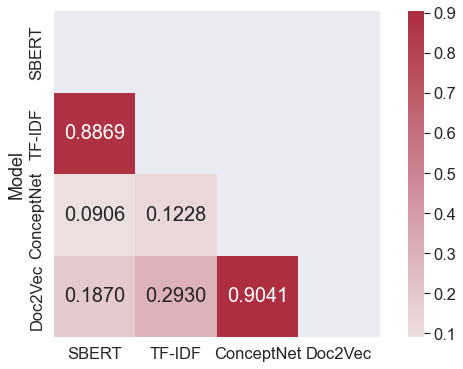

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


corr=pd.read_csv('/headmap_models.csv')
corr=corr.set_index('Model')
# Create a mask
mask = np.triu(np.ones_like(corr, dtype=bool))

# Create a custom divergin palette
cmap = sns.diverging_palette(100, 7, s=75, l=40,
                            n=5, center="light", as_cmap=True)

plt.figure(figsize=(10, 6))
sns.set(font_scale=1.5)
sns.heatmap(corr, mask=mask, center=0, annot=True,
            fmt='.4f', square=True, cmap=cmap, annot_kws={"size":20})


plt.show();

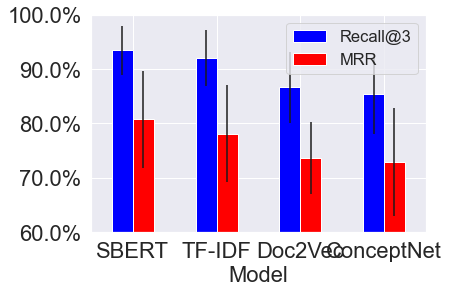

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.style as style 
style.available


# create dataframe
Recall = (93.43, 92.02, 86.67, 85.38)
MRR = (80.77, 78.15, 73.68, 72.98)
index = ['SBERT', 'TF-IDF', 'Doc2Vec','ConceptNet']
df = pd.DataFrame({'Recall@3': Recall, 'MRR': MRR}, index=index)

# dicts with errors
Recall_error = {93.43: {'min': 88.88,'max': 97.97}, 92.02: {'min': 86.83,'max': 97.20}, 86.67: {'min': 80.14,'max': 93.20}, 85.38: {'min': 77.98,'max': 92.78}}
MRR_error = {80.77: {'min': 71.81, 'max': 89.74}, 78.15: {'min': 69.31,'max': 86.99}, 73.68: {'min': 67.05,'max': 80.31}, 72.98: {'min': 63.02,'max': 82.94}}

# combine them; providing all the keys are unique
z = {**Recall_error, **MRR_error}

# plot
ax = df.plot.bar(rot=0, color=['blue','red'],fontsize=22)


plt.xlabel('Model',fontsize=22)
#plt.ylabel('(%)')
plt.ylim( [60,100])

ax.yaxis.set_major_formatter(mtick.PercentFormatter())


for p in ax.patches:
    x = p.get_x()  # get the bottom left x corner of the bar
    w = p.get_width()  # get width of bar
    h = p.get_height()  # get height of bar
    min_y = z[h]['min']  # use h to get min from dict z
    max_y = z[h]['max']  # use h to get max from dict z
    plt.vlines(x+w/2, min_y, max_y, color='k')  # draw a vertical line

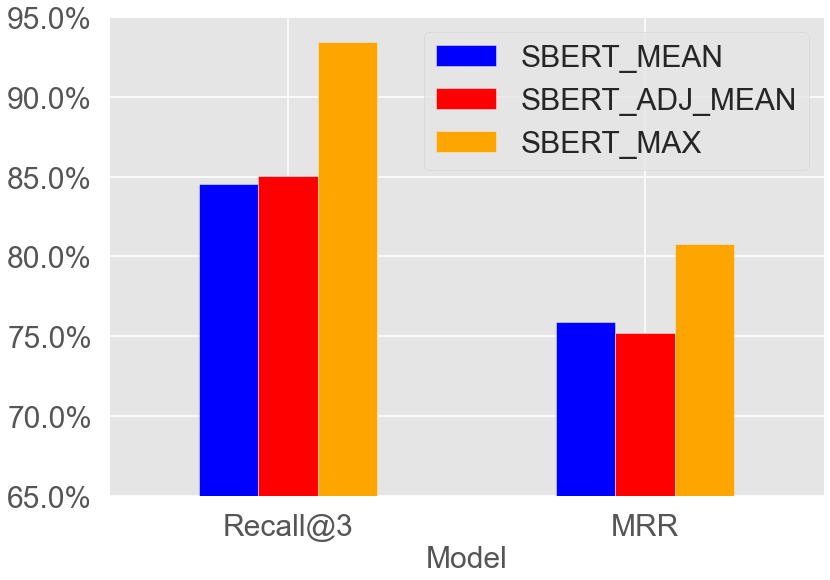

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.style as style 
style.available
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

# create dataframe

SBERT_MEAN =  (84.56183302,75.87585139)
SBERT_ADJ_MEAN = (85.04955446,75.20638572)
SBERT_MAX=(93.42746637,80.77453901)
index =  ['Recall@3','MRR']
df = pd.DataFrame({'SBERT_MEAN':SBERT_MEAN,'SBERT_ADJ_MEAN':SBERT_ADJ_MEAN,'SBERT_MAX':SBERT_MAX}, index=index)


# plot
ax = df.plot.bar(rot=0, color=['blue','red','orange'],fontsize=30)


plt.xlabel('Model',fontsize=30)
#plt.ylabel('(%)')
plt.ylim( [65,95])
ax.legend(fontsize=30)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())




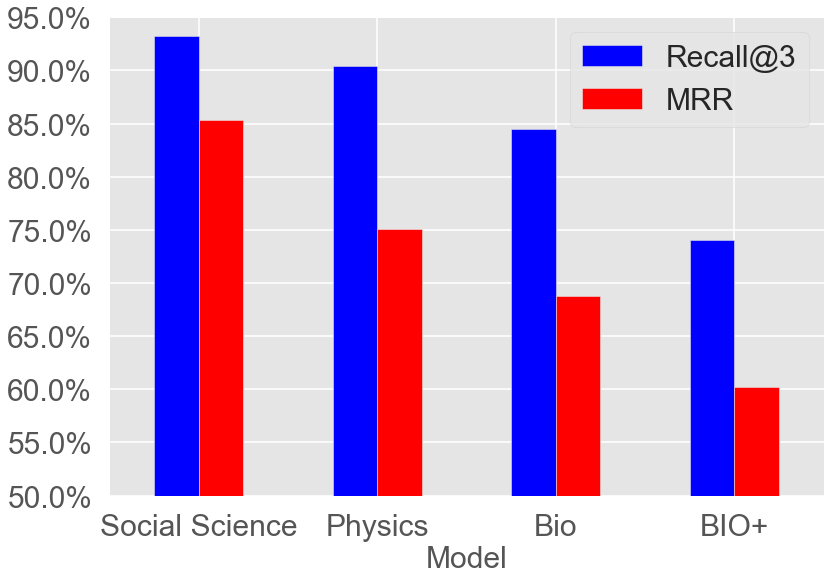

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.style as style 
style.available
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

# create dataframe

Recall = (93.26832575,90.38148569,84.46590909,74.02689046)
MRR = (85.37308917,75.06420716,68.74834716,60.24793065)
index = ['Social Science','Physics','Bio','BIO+']
df = pd.DataFrame({'Recall@3': Recall, 'MRR': MRR}, index=index)

# plot
ax = df.plot.bar(rot=0, color=['blue','red'],fontsize=30)


plt.xlabel('Model',fontsize=30)
#plt.ylabel('(%)')
plt.ylim( [50,95])
ax.legend(fontsize=30)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
